In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet34, resnet18
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_train = torchvision.datasets.ImageFolder(root='./data/train', transform=train_preprocess)
loader_train = torch.utils.data.DataLoader(dataset_train,
                                           batch_size=64,
                                           shuffle=True,
#                                            num_workers=4
                                          ) 

dataset_test = torchvision.datasets.ImageFolder(root='./data/test', transform=test_preprocess)
loader_test = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=64,
                                          shuffle=True,
#                                           num_workers=4
                                         ) 

In [3]:
class SimpleNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        base_model = resnet18(pretrained=True)
#         # 全層のパラメータを固定
#         for param in base_model.parameters():
#             param.requires_grad = False
            
        self.features = nn.Sequential(*[layer for layer in base_model.children()][:-2])
        self.attn_conv = nn.Sequential(
            nn.Conv2d(512, 1, 1),
            nn.Sigmoid()
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        B = x.size(0)
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.reshape(B, -1)
        
        return self.fc(x)

In [4]:
class SimpleAttentionNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        base_model = resnet18(pretrained=True)
        self.features = nn.Sequential(*[layer for layer in base_model.children()][:-2])
        self.attn_conv = nn.Sequential(
            nn.Conv2d(512, 1, 1),
            nn.Sigmoid()
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        self.mask_ = None

    def forward(self, x):
        x = self.features(x)
        
        attn = self.attn_conv(x)  # [B, 1, H, W]
        B, _, H, W = attn.shape
        self.mask_ = attn.detach().cpu()

        x = x * attn
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.reshape(B, -1)
        
        return self.fc(x)
    
    def make_cam(self, img, mask):
        cam = cv2.resize(mask, (224, 224))
        heatmap = (cam - np.min(cam))/(np.max(cam) - np.min(cam))    # 私の自作モデルではこちらを使用
        image = img.transpose(1, 2, 0)
        image -= np.min(image)
        image = np.uint8(255*image)
        image = np.minimum(image, 255)
        cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
        cam = np.float32(cam) + np.float32(image)
        cam = 255 * cam / np.max(cam)
        return np.uint8(cam)[:,:,::-1]
    
    def save_attention_mask(self, x, path):
        B = x.shape[0]
        self.forward(x)
        x = x.cpu() * torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1)
        x = x + torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
        
        fig, axs = plt.subplots(4, 3, figsize=(6, 8))
        plt.axis('off')
        for i in range(4):
            axs[i, 0].imshow(x[i].permute(1, 2, 0))
            axs[i, 1].imshow(self.mask_[i][0])
            cam = self.make_cam(x[i].numpy(), self.mask_[i][0].numpy())
            axs[i, 2].imshow(cam)
            
        plt.savefig(path)
        plt.close()
        return x, self.mask_, cam

In [5]:
clf_loss_func = torch.nn.CrossEntropyLoss()

In [6]:
gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

True
True


In [7]:
def train(model, loader, optimizer):
    model.train()
    correct = 0
    total = 0
    losses = []
    for X, y in tqdm(loader):
        X, y = X.to(device), y.to(device)
        clf = model(X)
        loss = clf_loss_func(clf, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        predict = clf.argmax(dim=1)
        correct += (predict == y.data).sum()
        total += len(y)
    
    return np.mean(losses), float(correct) / total

In [8]:
def valid(model, loader):
    model.eval()
  
    losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in tqdm(loader):
            X, y = X.to(device), y.to(device)
            clf = model(X)
            loss = clf_loss_func(clf, y)

            losses.append(loss.item())

            predict = clf.argmax(dim=1)
            correct += (predict == y).sum().item()
            total += len(y)
            
    return np.mean(losses), float(correct) / total

In [9]:
# model = SimpleNetwork(2)
model = SimpleAttentionNetwork(2)
model = model.to(device)

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

# output_dir = os.path.join(OUTPUT_DIR, "simple/attentions")
# os.makedirs(output_dir, exist_ok=True)

best_loss = 1e+10
# best_state = None
earlystop_counter = 0
for epoch in range(5):
    train_loss, train_acc = train(model, loader_train, optimizer)
    val_loss, val_acc = valid(model, loader_test)

    if val_loss < best_loss:
#         earlystop_counter = 0
        best_loss = val_loss
#         best_state = model.cpu().state_dict()
#         model.cuda()
    else:
        earlystop_counter += 1

    if earlystop_counter > 10:
        break
    
#     scheduler.step()
        
    print('Epoch: {}'.format(epoch))
    print("train loss: {:.2f}, train acc: {:.2f}%".format(train_loss, train_acc*100.))
    print("val loss: {:.2f}, val acc: {:.2f}%".format(val_loss, val_acc*100.))

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0
train loss: 0.29, train acc: 86.60%
val loss: 0.07, val acc: 97.40%
Epoch: 0
train loss: 0.29, train acc: 86.60%
val loss: 0.07, val acc: 97.40%


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1
train loss: 0.08, train acc: 97.08%
val loss: 0.06, val acc: 97.60%
Epoch: 1
train loss: 0.08, train acc: 97.08%
val loss: 0.06, val acc: 97.60%


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2
train loss: 0.05, train acc: 98.18%
val loss: 0.05, val acc: 98.30%
Epoch: 2
train loss: 0.05, train acc: 98.18%
val loss: 0.05, val acc: 98.30%


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3
train loss: 0.04, train acc: 98.56%
val loss: 0.04, val acc: 98.00%
Epoch: 3
train loss: 0.04, train acc: 98.56%
val loss: 0.04, val acc: 98.00%


100%|██████████| 16/16 [00:04<00:00,  3.52it/s]

Epoch: 4
train loss: 0.04, train acc: 98.84%
val loss: 0.04, val acc: 98.60%


Epoch: 4
train loss: 0.04, train acc: 98.84%
val loss: 0.04, val acc: 98.60%


In [13]:
for img, target in loader_test:
    img = img.cuda()
    imgs, masks, cams = model.save_attention_mask(img, os.path.join('.', 'out.png'))
    break

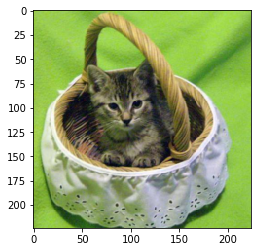

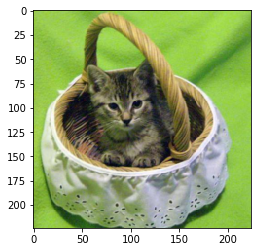

In [14]:
plt.imshow(imgs[0].permute(1, 2, 0))

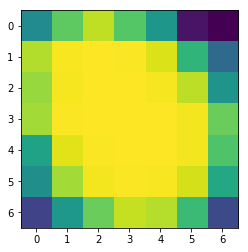

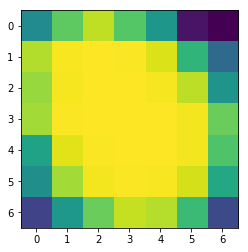

In [17]:
plt.imshow(masks[0][0])

In [78]:
import cv2
cam = cv2.resize(masks.numpy()[0][0], (224, 224))
heatmap = (cam - np.min(cam))/(np.max(cam) - np.min(cam))    # 私の自作モデルではこちらを使用
image = imgs.numpy()[0].transpose(1, 2, 0)
image -= np.min(image)
image = np.uint8(255*image)
image = np.minimum(image, 255)
cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
cam = np.float32(cam) + np.float32(image)
cam = 255 * cam / np.max(cam)

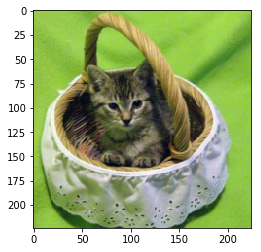

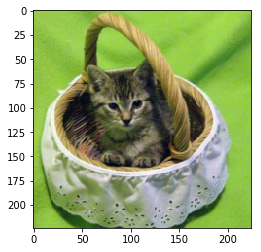

In [80]:
plt.imshow(image)

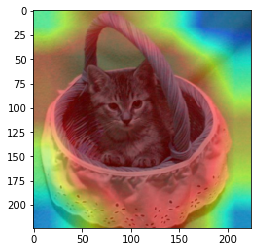

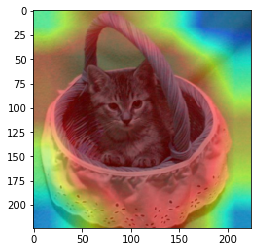

In [81]:
plt.imshow(np.uint8(cam)[:,:,::-1])

In [58]:
cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
plt.imshow(cam[:,:,::-1])